### Read and analyse the QVP output files

In [1]:
import sys
sys.path.append('/home/silke/Python/radarlecture2016/radarmeteorology/common')
import warnings
warnings.filterwarnings('ignore')
from helper import create_filename
import pandas as pd 
import numpy as np
import datetime as dt
from scipy import stats
import wradlib as wrl
from scipy import ndimage
import math
import matplotlib.pyplot as pl
import matplotlib as mpl
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import os
import glob
import scipy
from pandas import rolling_median
from scipy import interpolate
from scipy.stats import linregress
import numpy.ma as ma
from numpy import asarray as ar

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:44:13.863384. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
#%pylab

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:44:24.296234. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
def get_miub_cmap():
    startcolor = 'white'  # a dark olive
    color1 = '#8ec7ff'#'cyan'    # a bright yellow
    color2 = 'dodgerblue'
    color3 = 'darkgreen'
    #color3 = 'lime'
    color4 = 'yellow'
    color5 = 'darkorange'
    color6 = 'red'
    #color7 = 'purple'
    endcolor = 'darkmagenta'    # medium dark red
    colors = [startcolor, color1, color2, color3, color4, color5, color6, endcolor]
    return mpl.colors.LinearSegmentedColormap.from_list('miub1',colors)


/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:44:24.305628. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [4]:
def add_cbar(im, ticks, norm):
    cbar = pl.colorbar(im[-1], norm=norm, boundaries=ticks, pad=0.05)
    cbar.locator = mpl.ticker.FixedLocator(ticks)
    cbar.update_ticks()
    return cbar

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:44:24.602612. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [5]:
def get_norm(ticks):
    cmap = get_miub_cmap()
    norm = mpl.colors.BoundaryNorm(ticks, cmap.N)
    return norm

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:44:24.674934. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [26]:
def melting_layer_qvp(qvp_zh,qvp_zdr,qvp_rhohv,elevation,dr,bins,height_limit=""):
    """
    A melting layer detection method based on QVP data of ZH, ZDR, and RHOHV. Returns the location of the 
    top and bottom of the melting layer. 
    
    Inputs are....
    -QVP data of ZH, ZDR, and RHOhv (qvp_zh,qvp_zdr,qvp_rhohv).where x is height, and y is   
    -The elevation angle of the qvps (elevation).
    -The range step (dr)
    -The number of bins for range(bins)
    -Height_limit is optional limit. It will cut the data to certain height. This can improve the functioning because sometimes the top of the clouds produce problems.
    
    Created on Tuesday April 11 2017

    bhickman@uni-bonn.de
    

    """   
    re=6374000.
    ke=4./3. 
    range_bin_dist=100.
    radar_height=99.5
    r=np.linspace(0, (bins-1)*100,bins)
    #beam_height=(np.sqrt( r**2 + (ke*re)**2 + 2*r*ke*re*np.sin(np.radians(elevation)) )- ke*re)/1000
    beam_height = (wrl.georef.beam_height_n(r, round(elevation,1))
                   + radar_height) / 1000

    ############################################################
    # Step 1Normalize QVP data 
   
    #initiating empty arraysfor normalized data
    z0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1])) 
    z2f=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1])) 
    rho0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))
    zdr0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))

    for ii in range(z0.shape[1]):
        #normalize Z
        
        z2=np.copy(qvp_zh[:,ii])
        zmask2= np.where((z2 <= 0) | (z2>60))
        z2[zmask2]=np.nan
        z=np.copy(qvp_zh[:,ii])
        zmask= np.where((z < -10) | (z>60))
        z[zmask]=np.nan
        
        z0[:,ii]=(z-np.nanmin(z))/(np.nanmax(z)-np.nanmin(z))
        z2f[:,ii]=z2
        #normalize rho
        rho=np.copy(qvp_rhohv[:,ii])
        rhomask= np.where((rho <0.65) | (rho>1)) #rho thresholds
        rho[rhomask]=np.nan
        rho0[:,ii]=(rho-np.nanmin(rho))/(np.nanmax(rho)-np.nanmin(rho))
        
        #normalize ZDR
        zd=np.copy(qvp_zdr[:,ii])
        zdmask= np.where((zd < -1)|(zd > 4))
        zd[zdmask]=np.nan
        zdr0[:,ii]=(zd-np.nanmin(zd))/(np.nanmax(zd)-np.nanmin(zd))
        
    ############################################################ 
    #removing profiles with too few data (>93% of array is nan)
    per=np.zeros(z0.shape[1])
    for ii in range(z0.shape[1]):
        zt=z0[:,ii]
        tnan=np.count_nonzero(np.isnan(zt))
        tot=np.float(z0.shape[0])
        per[ii]=tnan/tot*100
    for ii in range(z0.shape[1]):
        if per[ii]>=93.:
            z0[:,ii]=np.nan
            zdr0[:,ii]=np.nan
            rho0[:,ii]=np.nan
        else:
            z0[:,ii]=z0[:,ii]  
            zdr0[:,ii]=zdr0[:,ii]  
            rho0[:,ii]=rho0[:,ii]  
            
    ############################################################ 
    #### Step 2combining three normalized variables into single varible (IMcomb) #### 
    #IMcomb =(zdr0*(1-rho0)*z0)
    ## A try for cases where identified bottom is above top of ML
    #IMcomb =(zdr0*zdr0*(1-rho0)*z0)
    #print('z2f',z2f)
    IMcomb =((z0))
    #IMcomb =(np.log10(z0+1))
    #print('IMcomb',IMcomb)
    ############################################################ 
    #### STEP 3 SOBEL Filter ####
    dyy= ndimage.sobel(IMcomb, 0)
    dy= ndimage.sobel(dyy, 0)
    #dy= ndimage.laplace(IMcomb)
    
    ############################################################ 
    #### STEP 4 Threshold ####
    ml_mask=np.where(np.abs(dy)<.02)
    dy[ml_mask]=0.
    
    ############################################################ 
    #Step 4b Height mask
    if not height_limit:
        height_limit=""
    else:
        height_limit=np.asfarray(height_limit)
        height_mask=np.where(beam_height>height_limit)
        dy[height_mask]=np.nan
    
    ############################################################         
    #### Step 5 ML Height min and max ####
    mlh_ind=np.zeros(IMcomb.shape[1])
    ml_top=np.zeros(dy.shape[1])
    ml_bottom=np.zeros(dy.shape[1])
    mlh_top=np.zeros(dy.shape[1])
    mlh_bottom=np.zeros(dy.shape[1])
    for ii in range(dy.shape[1]):
        d=dy[:,ii]
        #print np.nansum(d), ii
        if np.nansum(d)==math.isnan(np.nansum(d)):
            ml_bottom[ii]=-999
        else: 
            ml_bottom[ii]=np.nanargmax(d)
        if np.nansum(d)==math.isnan(np.nansum(d)):
            ml_top[ii]=999
        else:
            ml_top[ii]=np.nanargmin(d)
            
    for ii in range(dy.shape[1]):
        if ml_bottom[ii]==-999:
            mlh_bottom[ii]=-999
        else:
            #print("ml_bottom[ii]",ml_bottom[ii])
            mlh_bottom[ii]=beam_height[int(ml_bottom[ii])]

    mlh_bottom[mlh_bottom==-999]=np.nan
    for ii in range(dy.shape[1]):
        if ml_top[ii]==999:
            mlh_top[ii]=999
        else:
            mlh_top[ii]=beam_height[int(ml_top[ii])]
    mlh_top[mlh_top==999]=np.nan

    #Remove MLH_top which are below the MLH_bottom
    for ii in range(len(mlh_bottom)):
        if mlh_top[ii]<=mlh_bottom[ii]:
            mlh_top[ii]=np.nan
            
    ############################################################       
    #### Step 6 Median ML ######
    MED_mlh_bot=pd.rolling_median(mlh_bottom,min_periods=1,center=False,window=36)
    MED_mlh_top=pd.rolling_median(mlh_top,min_periods=1,center=False,window=36)


    if  qvp_zh.ndim>1:
        bh=np.array([beam_height,]*qvp_zh.shape[1]).transpose()
    else:
        bh=beam_height

    ############################################################       
    # Step 7: Step 5 is run again, but this time after discarding the gradient image above ...
    #(1 + fML,height) · MED_mlh_top and below (1 − fML,height ) · MED_mlh_bot , assuming the ML is a relatively 
    # flat structure. This helps to remove the possible contamination by ground echoes or small embedded cells 
    #of intense rainfall. The chosen value for fML,height is 0.3
    mlh_ind=np.zeros(IMcomb.shape[1])
    
    ml_top=np.zeros(IMcomb.shape[1])
    ml_bottom=np.zeros(IMcomb.shape[1])

    fMLH=0.3
    IMabove=(1 + fMLH) * MED_mlh_top
    IMbelow=(1 - fMLH) * MED_mlh_bot
    
    h_ind=np.where((bh>IMabove)|(bh<IMbelow))
    ml_new=np.copy(dy)
    ml_new[h_ind]=np.nan
    mlh_top=np.zeros(ml_new.shape[1])
    mlh_bottom=np.zeros(ml_new.shape[1])
    for ii in range(dy.shape[1]):
        d=ml_new[:,ii]
        if np.nansum(d)==math.isnan(np.nansum(d)):
            ml_bottom[ii]=-999
        else: 
            ml_bottom[ii]=np.nanargmax(d)
        if np.nansum(d)==math.isnan(np.nansum(d)):
            ml_top[ii]=999
        else:
            ml_top[ii]=np.nanargmin(d)

   
    for ii in range(dy.shape[1]):
        if ml_bottom[ii]==-999:
            mlh_bottom[ii]=-999
        else:
            mlh_bottom[ii]=beam_height[int(ml_bottom[ii])]       
    mlh_bottom[mlh_bottom==-999]=np.nan

    for ii in range(ml_new.shape[1]):
        if ml_top[ii]==999:
            mlh_top[ii]=999
        else:
            mlh_top[ii]=beam_height[int(ml_top[ii])]
    mlh_top[mlh_top==999]=np.nan

    #Remove MLH_top which are below the MLH_bottom
    for ii in range(len(mlh_bottom)):
        if mlh_top[ii]<=mlh_bottom[ii]:
            # A try for very low MLs
            #mlh_top[ii]=np.nan
            #mlh_bottom[ii]=np.nan
            mlh_bottom[ii]=beam_height[int(1)]
            ml_bottom[ii]=1

    #print 'MLH bottom', np.nanmedian(mlh_bottom), 'MLH top', np.nanmedian(mlh_top)
    #print 'MLH bottom',np.nanmedian(mlh_bottom2),'MLH top', np.nanmedian(mlh_top2)

    #MED_mlh_bot=pd.rolling_median(mlh_bottom,min_periods=1,center=False,window=12)
    #MED_mlh_top=pd.rolling_median(mlh_top,min_periods=1,center=False,window=12)
 
    
    return mlh_top,mlh_bottom, ml_top, ml_bottom, beam_height

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 23:09:44.002156. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [7]:
def melting_layer_qvp2(qvp_zh,qvp_zdr,qvp_rhohv,elevation,dr,bins,height_limit=""):
    
    
    """
    A melting layer detection using QVP data of ZH, ZDR, and RHOHV based of work from WOlfensberger et al (2015). 
    Returns the location of the top and bottom of the melting layer. 
    
    Inputs are....
    -QVP data of ZH, ZDR, and RHOhv (qvp_zh,qvp_zdr,qvp_rhohv) .  
    -The elevation angle of the QVPs (elevation).
    -The range step (dr)
    -The number of range bins (bins)
    
    Outputs are....
    –Melting layer top and bottom altitudes (mlh_top, mlh_bottom)
    
    Created on April 11 2017
    Modified on May 9th 2017
        –added a minimum threshold to IM to help in when no melting layer is present
        –Stricter filtering of mlt and mlb
    
    Author
    Brandon Hickman
    University of Bonn
    bhickman@uni-bonn.de
    
    """
    ############################################################
    #Beam Height
    re=6374000.
    ke=4./3. 
    range_bin_dist=100.
    radar_height=99.5
    r=np.linspace(0, (bins-1)*100,bins)
    #beam_height=(np.sqrt( r**2 + (ke*re)**2 + 2*r*ke*re*np.sin(np.radians(elevation)) )- ke*re)/1000
    beam_height = (wrl.georef.beam_height_n(r, round(elevation,1))
                   + radar_height) / 1000
    
    ############################################################
    # Step 1 Normalize QVP data 
   
    #initiating empty arraysfor normalized data
    z0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1])) 
    rho0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))
    zdr0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))

    for ii in range(z0.shape[1]):
        #normalize Z
        z=np.copy(qvp_zh[:,ii])
        
        zmask= np.where((z < -10) | (z>60))
        z[zmask]=np.nan
        z0[:,ii]=(z-np.nanmin(z))/(np.nanmax(z)-np.nanmin(z))
        
        #normalize rho
        rho=np.copy(qvp_rhohv[:,ii])
        rhomask= np.where((rho <0.65) | (rho>1)) 
        rho[rhomask]=np.nan
        rho0[:,ii]=(rho-np.nanmin(rho))/(np.nanmax(rho)-np.nanmin(rho))
        
        #normalize ZDR
        zd=np.copy(qvp_zdr[:,ii])
        zdmask= np.where((zd < 0.1)|(zd > 4))
        zd[zdmask]=np.nan
        zdr0[:,ii]=(zd-np.nanmin(zd))/(np.nanmax(zd)-np.nanmin(zd))
        
    ############################################################ 
    #removing profiles with too few data (>93% of array is nan)
    per=np.zeros(z0.shape[1])
    for ii in range(z0.shape[1]):
        zt=z0[:,ii]
        tnan=np.count_nonzero(np.isnan(zt))
        tot=np.float(z0.shape[0])
        per[ii]=tnan/tot*100
    for ii in range(z0.shape[1]):
        if per[ii]>=93.:
            z0[:,ii]=np.nan
            zdr0[:,ii]=np.nan
            rho0[:,ii]=np.nan
        else:
            z0[:,ii]=z0[:,ii]  
            zdr0[:,ii]=zdr0[:,ii]  
            rho0[:,ii]=rho0[:,ii]  
            
    ############################################################ 
    #### Step 2combining three normalized variables into single varible (IMcomb) #### 
    IMcomb =zdr0*zdr0*(1-rho0)*z0
    cut=0.15 #removes lowest which helps when melting layer snt present (value not verified yet)
    m=np.where(IMcomb<cut)
    IMcomb[m]=0
    
    ############################################################ 
    #### STEP 3 SOBEL Filter ####
    dy= ndimage.sobel(IMcomb, 0)
    
    ############################################################ 
    #### STEP 4 Threshold ####
    ml_mask=np.where(np.abs(dy)<.02)
    dy[ml_mask]=np.nan
    
    ############################################################ 
    #Step 4b Height mask
    if not height_limit:
        height_limit=""
    else:
        height_limit=np.asfarray(height_limit)
        height_mask=np.where(beam_height>height_limit)
        dy[height_mask]=np.nan
    
    ############################################################         
    #### Step 5 ML Height min and max ####
    mlh_ind=np.zeros(IMcomb.shape[1])
    ml_top=np.zeros(dy.shape[1])
    ml_bottom=np.zeros(dy.shape[1])
    mlh_top=np.zeros(dy.shape[1])
    mlh_bottom=np.zeros(dy.shape[1])
    
    for ii in range(dy.shape[1]):
        d=dy[:,ii]
        if np.nansum(np.abs(d))==0:
            ml_bottom[ii]=-999
        else: 
            ml_bottom[ii]=np.nanargmax(d)
        if np.nansum(np.abs(d))==0:
            ml_top[ii]=999
        else:
            ml_top[ii]=np.nanargmin(d)
    
    for ii in range(dy.shape[1]):
        if ml_bottom[ii]==-999:
            mlh_bottom[ii]=-999
        else:
            mlh_bottom[ii]=beam_height[int(ml_bottom[ii])]
    mlh_bottom[mlh_bottom==-999]=np.nan


    for ii in range(dy.shape[1]):
        if ml_top[ii]==999:
            mlh_top[ii]=999
        else:
            mlh_top[ii]=beam_height[int(ml_top[ii])]
    mlh_top[mlh_top==999]=np.nan
    ############################################################       
    #### Step 6 Median ML ######
    MED_mlh_bot=pd.rolling_median(mlh_bottom,min_periods=3,center=False,window=12)
    MED_mlh_top=pd.rolling_median(mlh_top,min_periods=3,center=False,window=12)

    mb=np.nanmedian(mlh_bottom)
    mt=np.nanmedian(mlh_top)

    if  qvp_zh.ndim>1:
        bh=np.array([beam_height,]*qvp_zh.shape[1]).transpose()
    else:
        bh=beam_height

    ############################################################       
    # Step 7: Step 5 is run again, but this time after discarding the gradient image above ...
    #(1 + fML,height) · MED_mlh_top and below (1 − fML,height ) · MED_mlh_bot , assuming the ML is a relatively 
    # flat structure. This helps to remove the possible contamination by ground echoes or small embedded cells 
    #of intense rainfall. The chosen value for fML,height is 0.3
    
    fMLH=0.3

    
    IMabove=(1 + fMLH) * mt
    IMbelow=(1 - fMLH) * mb
    if  z.ndim>1:
        bh=np.array([beam_height,]*zh.shape[1]).transpose()
    else:
        bh=beam_height
    h_ind=np.where((bh>IMabove))#|(bh<IMbelow))

    ml_new=np.copy(dy)
    ml_new[h_ind]=np.nan


    ml_top2=np.zeros(dy.shape[1])
    ml_bottom2=np.zeros(dy.shape[1])
    mlh_ind=np.zeros(IMcomb.shape[1])
    for ii in range(dy.shape[1]):
        d=ml_new[:,ii]
        if np.nansum(np.abs(d))==0:
            ml_bottom2[ii]=-999
        else: 
            ml_bottom2[ii]=np.nanargmax(d)
        if np.nansum(np.abs(d))==0:
            ml_top2[ii]=999
        else:
            ml_top2[ii]=np.nanargmin(d)


    mlh_top2=np.zeros(ml_new.shape[1])
    mlh_bottom2=np.zeros(ml_new.shape[1])
    for ii in range(dy.shape[1]):
        if ml_bottom2[ii]==-999:
            mlh_bottom2[ii]=-999
        else:
            mlh_bottom2[ii]=beam_height[int(ml_bottom2[ii])]       
    mlh_bottom2[mlh_bottom2==-999]=np.nan

    for ii in range(ml_new.shape[1]):
        if ml_top2[ii]==999:
            mlh_top2[ii]=999
        else:
            mlh_top2[ii]=beam_height[int(ml_top2[ii])]
    mlh_top2[mlh_top2==999]=np.nan

    #Remove MLH_top and bottom which are below the MLH_bottom
    for ii in range(len(mlh_bottom)):       
        if mlh_top[ii]<=mlh_bottom[ii]:
            mlh_bottom[ii]=beam_height[int(1)]
            ml_bottom[ii]=1
            # A try for very low MLs
            #mlh_top[ii]=np.nan
            #mlh_bottom[ii]=np.nan                    
    
    return mlh_top2,mlh_bottom2, ml_top2, ml_bottom2, beam_height

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 09:06:15.247209. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Local station metadata

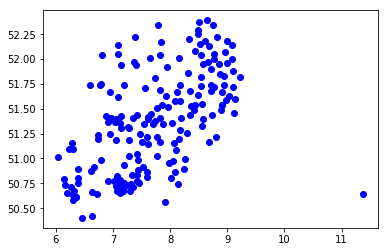

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:49:09.361799. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [7]:
import numpy as np
import pandas
import csv

# load csv data via numpy.loadtxt
# fastest method but uncomfortable

filename = os.path.join('/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations', 'LUA-Stationen2_Bonn.csv')

# create datatype of data to be read
meta_type = np.dtype({'names': ['Station',  'Geogr.Laenge', 'Geogr.Breite'],
                'formats': ['|S32', np.float, np.float]})

# load data with some definitions
meta = np.loadtxt(filename, delimiter=',', usecols=[3,6,7], unpack=False, dtype=meta_type, skiprows=0,
                  converters={0: lambda s: float(s.strip() or 0)})
                  
#print(meta)
#print(meta.dtype)
fig, ax = pl.subplots()
for st, lon, lat in meta:
    ax.plot(lon, lat, marker='o', color='b', label=st)
pl.show()


Load radar metadata

In [8]:
# convective event
#f = create_filename('n_ppi_180deg', 12, 4, 2016, 11, 20)
#f = create_filename('ppi_1p5deg', 12, 4, 2013, 11, 20)
#lokal herkopiert
f='/home/silke/Python/projects/climatology/2016-04-12--11:20:00,00.mvol'
rdata, rmeta = wrl.io.read_GAMIC_hdf5(f)
#print(rmeta)
r = rmeta['SCAN0']['r']
r=np.arange(100,5100,100)
#print(r)
az = rmeta['SCAN0']['az']
sitecoords = (rmeta['VOL']['Longitude'], rmeta['VOL']['Latitude'], 
              rmeta['VOL']['Height'])

proj_radar = wrl.georef.create_osr("aeqd", lat_0=sitecoords[1],
                               lon_0=sitecoords[0])
radius = wrl.georef.get_earth_radius(sitecoords[1], proj_radar)

proj_wgs = wrl.georef.get_default_projection()

cent_lon, cent_lat = wrl.georef.polar2centroids(r, az, sitecoords)

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:49:13.903022. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


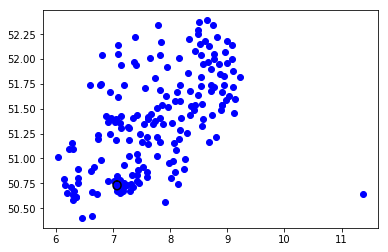

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:49:16.592460. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [9]:
fig, ax = pl.subplots()
for st, lon, lat in meta:
    ax.plot(lon, lat, marker='o', color='b', label=st)
pl.plot(cent_lon[:,-1], cent_lat[:,-1], 'k')
#pl.show()

Get stations within radar domain

In [10]:
from matplotlib.path import Path

x = np.array([m[1] for m in meta])
y = np.array([m[2] for m in meta])
station = np.array([m[0] for m in meta])
points = np.squeeze(np.dstack((x,y)))
vertices = np.squeeze(np.dstack((cent_lon[:,-1], cent_lat[:,-1])))
pth = Path(vertices)

contains = pth.contains_points(points)
pts = points[contains==True]
stations = station[contains==True]

print(points.shape, pts.shape)
x, y = pts[:, 0], pts[:, 1]

((196, 2), (9, 2))


/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:49:21.077858. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


###Import and save station data, needs to be done only once

In [12]:
import datetime as dt
import glob
# load lanuv data
#fpath = '/automount/agh/Projects/regendaten/Read/.lanuv/'
fpath = '/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations'
meta_type = np.dtype({'names': ['Time',  'Rain'], 
                      'formats': [dt.datetime, np.float]})

rain = []
data = np.array([])
for i, st in enumerate(stations):
    filename = os.path.join(fpath, st[:12])
    print(st)
    filename = glob.glob(filename + '*')
    # create datatype of data to be read

    # load data with some definitions
    print(st, filename)
    try:
        data = np.loadtxt(filename[0], delimiter=' ', usecols=[0,1], unpack=False, dtype=meta_type, skiprows=0,
                          converters={0: lambda x: dt.datetime.strptime(x, "%Y%m%d%H%M%S")})#, 1: lambda s: s.strip() or ''})
        np.savez_compressed(st, data=data)
    except:
        pass

Zeisigweg
('Zeisigweg', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/Zeisigweg.csv'])
EndenichWiesenweg
('EndenichWiesenweg', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/EndenichWiesenweg.csv'])
Heizkraftwerk
('Heizkraftwerk', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/Heizkraftwerk.csv'])
Ippendorf
('Ippendorf', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/Ippendorf.csv'])
KlaeranlageHersel
('KlaeranlageHersel', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/KlaeranlageHersel.csv'])
Betriebshof
('Betriebshof', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/Betriebshof.csv'])
Lessenich
('Lessenich', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/Lessenich.csv'])
Medinghoven
('Medinghoven', ['/home/silke/Python/rad

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-05-23 08:23:11.062942. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Load station .npz data

In [11]:
def load_station(station):
    data = np.load(station.decode() + '.npz', encoding='bytes')
    print(data)
    return data['data']

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:49:33.013329. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


(2103839,)


(0, 4)

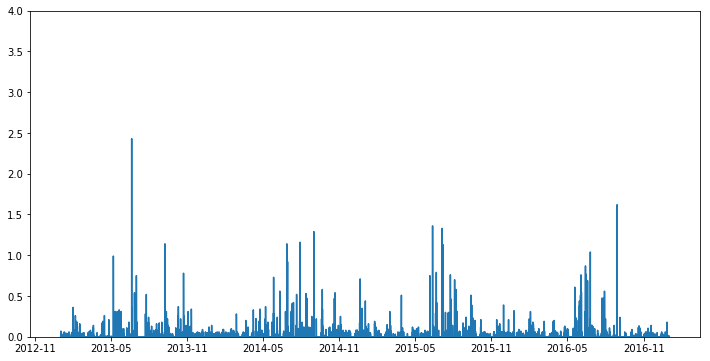

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:49:35.244315. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [12]:
st0 = load_station(stations[5])
print(st0.shape)
fig = pl.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(st0['Time'], st0['Rain'])
ax.set_ylim(0,4)

In [13]:
print(stations[0])
print(stations[1])
print(stations[2])
print(stations[3])
print(stations[4])
print(stations[5])
print(stations.shape)

Zeisigweg
EndenichWiesenweg
Heizkraftwerk
Ippendorf
KlaeranlageHersel
Betriebshof
(9,)


/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:50:35.733523. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Create array of datetime objects

#Load dates, the events collected in the folder

In [14]:
datepath="/home/silke/Python/output/Riming/"
#dates = sorted(glob.glob(datepath + "20*/"))
#print(dates[1][33:43])
#for l in range(len(dates)):
#    dates[l]=dates[l][33:43]
#print(dates)
###Versteh Fehler nicht, lasse erstmal 2013-05-29 weg
##Ich glaub 2015-04-02 gibts keine Wippeninfo, ebenfalls weg, fast das komplette 2015 faellt weg
##-> war nur bei Lanuv-Stationen so, hab nun Stadt Bonn Daten drin
##Ich glaub '2015-04-04'ist die ML zu niedrig
##, '2016-01-10' '2016-01-11', '2016-01-13'taugen auch nichts
## , '2016-01-02',  hab ich nun noch nicht bei Stadt Bonn Daten!!!
datesredu=['2013-04-12','2014-05-06','2014-05-27','2014-06-28','2014-07-08','2014-07-09','2014-10-07','2014-10-08','2014-11-04','2014-12-12',
       '2015-03-29','2015-04-02','2015-05-03',
       '2015-06-02', '2015-06-23', '2015-08-04','2015-08-17','2015-08-27','2015-09-01','2015-09-13', 
       '2015-09-16','2015-09-22','2015-10-05','2015-11-17', '2015-11-19', '2015-11-29', '2015-12-04', 
       '2015-12-08','2015-12-09',
       '2015-12-11', '2015-12-16', '2015-12-22', '2015-12-25','2016-01-07','2016-01-30','2016-09-04']
#erste Zeile, 2 Termine neu
#zweite Zeile bis 7 neu
dates=['2014-10-09','2014-07-05','2014-08-26',
    '2015-06-22','2015-02-27','2015-01-08','2015-01-02','2014-12-19','2014-11-16','2014-10-15',
    '2013-04-12','2013-07-03','2014-05-06','2014-05-27','2014-06-28','2014-07-08','2014-07-09','2014-10-07','2014-10-08','2014-11-04','2014-12-12',
       '2015-03-29','2015-04-02','2015-05-03','2015-05-29',
       '2015-06-02', '2015-06-13','2015-06-23', '2015-07-13','2015-08-04','2015-08-08','2015-08-17',
       '2015-08-27','2015-09-01','2015-09-13', 
       '2015-09-16','2015-09-22','2015-10-05','2015-11-06','2015-11-17', '2015-11-19', '2015-11-20',
       '2015-11-29', '2015-12-08','2015-12-09',
       '2015-12-11', '2015-12-16', '2015-12-22', '2015-12-25','2016-01-02','2016-01-07','2016-09-04']
print(dates)


['2014-10-09', '2014-07-05', '2014-08-26', '2015-06-22', '2015-02-27', '2015-01-08', '2015-01-02', '2014-12-19', '2014-11-16', '2014-10-15', '2013-04-12', '2013-07-03', '2014-05-06', '2014-05-27', '2014-06-28', '2014-07-08', '2014-07-09', '2014-10-07', '2014-10-08', '2014-11-04', '2014-12-12', '2015-03-29', '2015-04-02', '2015-05-03', '2015-05-29', '2015-06-02', '2015-06-13', '2015-06-23', '2015-07-13', '2015-08-04', '2015-08-08', '2015-08-17', '2015-08-27', '2015-09-01', '2015-09-13', '2015-09-16', '2015-09-22', '2015-10-05', '2015-11-06', '2015-11-17', '2015-11-19', '2015-11-20', '2015-11-29', '2015-12-08', '2015-12-09', '2015-12-11', '2015-12-16', '2015-12-22', '2015-12-25', '2016-01-02', '2016-01-07', '2016-09-04']


/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 21:50:42.123631. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Loop over all events

In [27]:
# read the QVP data
#for k in range(len(dates)):
for k in range(0,1):    
    date=dates[k]
    print(date)
    #date="2013-04-12"

    zh=[]
    zv=[]
    kdp=[]
    rhohv=[]
    phi=[]
    kdp=[]

    # hier mit readlines und append
    # noch automatisieren für die verschiedenen Daten/Subfolder
    path="/home/silke/Python/output/Riming/" + date +"/textfiles/"
    in_file_zh= open(path + "zh_output_Bonn_18.0_" + date + ".txt","r")

    timeline=in_file_zh.readlines()
    in_file_zh.close()
    time=timeline[4].split()
    #Enthaelt die verschiedenen Zeitpunkte
    time=time[3:]
    dates0 = dt.datetime.strptime(dates[k]+time[0], '%Y-%m-%d%H:%M')
    dates1 = dt.datetime.strptime(dates[k]+time[-1], '%Y-%m-%d%H:%M')
    print(dates0, dates1)
    #print(time)
    #Groesse des Feldes und damit Anzahl der data-Columns, die wir wollen
    times=len(time)+2
    #print(times)
    in_file_zh= open(path + "zh_output_Bonn_18.0_" + date + ".txt","r")
    #zh =np.loadtxt(in_file_zh, skiprows=4, dtype = 'f4').transpose()
    zh =np.loadtxt(in_file_zh, skiprows=4, usecols = range(2,times,1), dtype = 'f4')

    path="/home/silke/Python/output/Riming/" + date + "/textfiles/"
    in_file_zdr= open(path + "zdr_output_Bonn_18.0_" + date + ".txt","r")
    zdr =np.loadtxt(in_file_zdr, skiprows=4, usecols = range(2,times,1), dtype = 'f4')

    path="/home/silke/Python/output/Riming/" + date + "/textfiles/"
    in_file_rhohv= open(path + "rho_output_Bonn_18.0_" + date + ".txt","r")
    rhohv =np.loadtxt(in_file_rhohv, skiprows=4, usecols = range(2,times,1), dtype = 'f4')

    path="/home/silke/Python/output/Riming/" + date + "/textfiles/"
    in_file_kdp= open(path + "kdp_output_Bonn_18.0_" + date + ".txt","r")
    kdp =np.loadtxt(in_file_kdp, skiprows=4, usecols = range(2,times,1), dtype = 'f4')

    path="/home/silke/Python/output/Riming/" + date + "/textfiles/"
    in_file_phi= open(path + "phi_output_Bonn_18.0_" + date + ".txt","r")
    phi =np.loadtxt(in_file_phi, skiprows=4, usecols = range(2,times,1),dtype = 'f4')


    #hier mit loadtxt, muß dtype hier so angegeben werden?
    #zh, zv, kdp, rhv, dlt, ah, ade =np.loadtxt(in_file, skiprows=2, usecols= (1,2,3,4,5,6,7), dtype = 'f4').transpose()
    print "das ist zh, benutzt loadtxt with comma\n", type(zh), type(zh[0])
    print "--------------------------------------------------------------------"

    # Create datetime arrays
    import datetime as dt
    from datetime import timedelta
    start = dates0
    end = dates1
    #start = dt.datetime(2013,4,12,0,1)
    #tarr = np.array([start + timedelta(minutes=i*5) for i in range(288)])
    tarr = np.arange(start, end + timedelta(minutes=5), timedelta(minutes=5))
    t5min=np.arange(start - timedelta(minutes=2), end + timedelta(minutes=7), timedelta(minutes=5))
    #thour=np.arange(start - timedelta(minutes=29), end + timedelta(minutes=50), timedelta(hours=1))
    #print(tarr)

    # Load and process station data

    #print(zh)
    #zhi = np.squeeze(wrl.trafo.idecibel(zh))
    good = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 19, 
            20, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 36, 37, 38, 
            39, 40, 41, 42, 45, 47, 48, 49, 50, 51, 52, 53, 54, 58, 
            60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 75, 77, 78, 79, 
            80, 83, 85, 86, 87, 88]
    # other good stations: 18, 21, 25, 28, 55, 57
    X1 = []
    Y1 = []
    for st, name in enumerate(stations):#good:
        
        try:
            st0 = load_station(stations[st])
        except:
            continue
        #st0 = load_station(st)
        t_MEZ = st0['Time']
        #ACHTUNG die Stationsdaten sind in MEZ angegeben, Radar in UTC, also -1h
        t = t_MEZ - timedelta(hours=1)
        rr = st0['Rain']
        #Zeiten von QVP
        #mit dem idx hat die 5minutenGeschichte funktioniert
        idx = (t>=dates0-timedelta(minutes=10)) & (t<=dates1+timedelta(minutes=10))  
        #brauch fuer die Stunden nun aber ein groesseres Fenster
        #idx = (t>=dates0-timedelta(minutes=40)) & (t<=dates1+timedelta(minutes=40))  
        #idx = (t>=dt.datetime(2013,4,12,1,0)) & (t<dt.datetime(2013,4,13,0,59))
        #idx = (t>=dt.datetime(2011,4,3,1,0)) & (t<dt.datetime(2011,4,4,0,59))
        #t1 = t[idx] - timedelta(hours=1)
        t1 = t[idx]
        #print('t1',t1)
        #print(len(np.nonzero(idx)[0]))
        if (len(np.nonzero(idx)[0]) > 10):
            
            #print(t1[0:15])
            off = (t1[0].minute % 5) - 1
            t2 = np.array(wrl.util.from_to(t1[0] - timedelta(minutes=off), t1[-1], 60))
            #print('t2',t2)
            rra = rr[idx] # in mm
            #print('t5',t5min), hat funktioniert       
            rr1 = wrl.util.aggregate_in_time(rra, t1, t5min, func='nansum')  
            #will nun aber Stundenmittel
            #rr1 = wrl.util.aggregate_in_time(rra, t1, thour, func='nansum') 

            # musste um die 5minuten Mittel in mm/h angeben mal 12 nehmen
            Y=rr1*12
            #nun sind es dann aber schon mm/h, hab von einem Stundenintervall aufsummiert
            #Y=rr1
            mask = np.isnan(Y)
            #print(mask)
            Y[mask] = 0.0
            #mask = ~np.isnan(X) & np.isfinite(Y)
            #X1.append(X[mask])
            Y1.append(Y)
            #Y1.append(Y)
    YD = np.array(Y1)
    print('YD',YD.shape)
    #Bestimmung der ML-Height
    elevation = 18.0
    dr = 100.0
    bins = zh.shape[0]
    times = zh.shape[1]
    #Kdp in der ML
    kdpml=np.zeros(times)
    #Differenz von PHI oberh und unterh der ML, +/-10 Indexhoehen
    diffml=np.zeros(times)
    #maximales phi, z, zdr in der ML
    phimax=np.zeros(times)
    zhmax=np.zeros(times)
    zdrmax=np.zeros(times)
    #dazugehoeriger Index
    phimaxi=np.zeros(times)
    zhmaxi=np.zeros(times)
    zdrmaxi=np.zeros(times)
    #minimales rhohv
    rhohvmin=np.zeros(times)
    #dazugehoeriger Index
    rhohvmini=np.zeros(times)
    #delta in ML
    deltaml=np.zeros(times)


    #bh=beam_height
    toph, bottomh, topi, bottomi, bh = melting_layer_qvp(zh,zdr,rhohv,elevation,dr,bins,height_limit=10.)
    mlthick = toph - bottomh
    #print('ML-Detectionoutput', topi, bottomi)
    ####temperature information
    #path="/home/silke/Python/projects/climatology/"
    #in_file_temp= open(path + "temp-" + date + ".dat","r")
    #ht8, ht10, ht15 =np.loadtxt(in_file_temp, skiprows=1, usecols = (1,2,3), dtype = 'f4')
    #print(ht8, ht10, ht15)
    ###
    # http://weather.uwyo.edu/upperair/sounding.html
    filename = os.path.join('/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations', 
                            'radio_'+dates[k]+'.txt')
    radio = np.genfromtxt(filename, skip_header=3, autostrip=True, 
                         invalid_raise=False)
    stemp = radio[:, 2]
    sheight = radio[:, 1]
    # remove nans
    idx = np.isfinite(stemp)
    stemp = stemp[idx]
    sheight = sheight[idx]
    # highres height
    ht = np.arange(0., 20000.)
    ipolfunc = interpolate.interp1d(sheight, stemp, kind='linear', 
                                    bounds_error=False)
    itemp = ipolfunc(ht)
    #highres temp
    mask1 = (itemp <= -14.99) & (itemp >= -15.01)
    mask2 = (itemp <= -9.99) & (itemp >= -10.01)
    mask3 = (itemp <= -7.99) & (itemp >= -8.01)
    h=ht[mask1]
    ht15=h[0]
    h=ht[mask2]
    ht10=h[0]
    h=ht[mask3]
    ht8=h[0]
    print(ht15, ht10, ht8)

    #90percentile of KDP, ZDR, Z between -10 and -15
    #print(bh)

    #ZDR in der DGL
    zdrdgl=np.zeros(times)
    #ZDR in der DGL
    kdpdgl=np.zeros(times)
    #Zh in der DGL
    zhdgl=np.zeros(times)

    for i in range(len(bh)):
        #nur zwischen -10 und -15 schauen, oder schon ab -8
        if(bh[i]<ht10/1000.):
            ht10i=i
        if(bh[i]<ht15/1000.):
            ht15i=i
    print(ht10i)
    print(bh[ht10i], bh[ht15i])
    # Determine 90percentile in the DGL
    #Index des 90sten
    path2="/home/silke/Python/projects/climatology/"
    f = open(path2 + 'out_'+ date +'.txt', 'wb')
#    print("%5s %4s %4s %5s %5s %5s %3s %2s %3s %4s %4s %4s %4s %4s %6s %5s %5s %5s %4s %5s %5s %5s %5s %5s" %
#              ('Time','ML_b','ML_t','ML_th','Kdp_ML','Phimax','D_ML','Dh', 
#               'Zh_ML','Zhh','Zdr_ML','Zdrh',
#               'R_ML','Rh','Kdp_D','Zdr_D', 'Zh_D', 'Zh_S', 'Zdr_S','St1', 'St2', 'St3', 'St4', 'St5'))
    f.write("%5s %4s %4s %5s %5s %5s %3s %2s %3s %4s %4s %4s %4s %4s %6s %5s %5s %5s %4s %5s %5s %5s %5s %5s" %
              ('Time','ML_b','ML_t','ML_th','Kdp_ML','Phimax','D_ML','Dh', 
               'Zh_ML','Zhh','Zdr_ML','Zdrh',
               'R_ML','Rh','Kdp_D','Zdr_D', 'Zh_D', 'Zh_S', 'Zdr_S','St1', 'St2', 'St3', 'St4', 'St5\n'))  
    print('timeslaenge',times)
    for i in range(times):
        if(topi[i]>=999 or topi[i]==np.nan):
            print('hello')
            topi[i]=np.nan
            bottomi[i]=np.nan
            toph[i]=np.nan
            bottomh[i]=np.nan
            diffml[i]=np.nan
            dh=np.nan
            kdpml[i]=np.nan
            phimax[i]=np.nan
            deltaml[i]=np.nan
            zhmax[i]=np.nan
            zdrmax[i]=np.nan
            rhohvmin[i]=np.nan
            zhmaxi[i]=np.nan
            zdrmaxi[i]=np.nan
            rhohvmini[i]=np.nan
        else:
        #print(topi[i],bottomi[i])
            print('index',topi[i],i)
            if(bh[int(bottomi[i])]>=0.4):
                index=int(topi[i]+10)+np.argmin(phi[int(topi[i]+10):int(topi[i])+20,i])
                diffml[i]=phi[index,i]-phi[int(bottomi[i]-10),i]
                dh=bh[int(index)]-bh[int(bottomi[i])-10]
                print('t,dh,diffml[i]', i, dh,diffml[i])
                kdpml[i]=diffml[i]/dh/2.
                #print(kdpml[i],diffml[i],mlthick[i])

                # Determine delta in the ML
                j=int(bottomi[i]-10)
                phimaxi[i]=j
                phimax[i]=phi[int(bottomi[i])-10,i]
                while j<int(index):
                    j = j+1
                    if phi[j,i]>phimax[i]:
                        phimax[i]=phi[j,i]
                        phimaxi[i]=j

                #print(phi[int(topi[i])+10,i], phi[int(bottomi[i])-10,i],phimax[i])
                deltaml[i]=phimax[i]-(phi[int(bottomi[i])-10,i]
                                      +2.*kdpml[i]*(bh[int(phimaxi[i])]-bh[int(bottomi[i])-10]))
            else:
                #glaube ich kann da nicht unterscheiden, muss 10 Schritte runter
                index=int(topi[i]+10)+np.argmin(phi[int(topi[i]+10):int(topi[i])+20,i])
                diffml[i]=phi[int(index),i]-phi[1,i]
                dh=bh[int(index)]-bh[1]
                kdpml[i]=diffml[i]/dh/2.
                #print(kdpml[i],diffml[i],mlthick[i])

                # Determine delta in the ML
                j=1
                phimax[i]=phi[j,i]
                phimaxi[i]=j
                while j<int(index):
                    j = j+1
                    if phi[j,i]>phimax[i]:
                        phimax[i]=phi[j,i]
                        phimaxi[i]=j

                #print(phi[int(topi[i])+10,i], phi[int(bottomi[i])-10,i],phimax[i])
                deltaml[i]=phimax[i]-(phi[1,i]+2.*kdpml[i]*(bh[int(phimaxi[i])]-bh[1]))
            #Determine other variables in the ML
            ##hilfe
            ##hilfe ende
            if(bh[int(bottomi[i])]>=0.4):                
                j=int(bottomi[i])
                zdrmaxi[i]=j
                zhmaxi[i]=j
                rhohvmini[i]=j
                zhmax[i]=zh[int(bottomi[i]),i]
                zdrmax[i]=zdr[int(bottomi[i]),i]
                rhohvmin[i]=rhohv[int(bottomi[i]),i]
                while j<int(index):
                    j = j+1
                    if zh[j,i]>zhmax[i]:
                        zhmax[i]=zh[j,i]
                        zhmaxi[i]=j
                    if zdr[j,i]>zdrmax[i]:
                        zdrmax[i]=zdr[j,i]
                        zdrmaxi[i]=j
                    if rhohv[j,i]<rhohvmin[i]:
                        rhohvmin[i]=rhohv[j,i]
                        rhohvmini[i]=j
            else:
                j=int(bottomi[i])
                zdrmaxi[i]=j
                zhmaxi[i]=j
                rhohvmini[i]=j
                zhmax[i]=zh[j,i]
                zdrmax[i]=zdr[j,i]
                rhohvmin[i]=rhohv[j,i]
                while j<int(index):
                    j = j+1
                    if zh[j,i]>zhmax[i]:
                        zhmax[i]=zh[j,i]
                        zhmaxi[i]=j
                    if zdr[j,i]>zdrmax[i]:
                        zdrmax[i]=zdr[j,i]
                        zdrmaxi[i]=j
                    if rhohv[j,i]<rhohvmin[i]:
                        rhohvmin[i]=rhohv[j,i]
                        rhohvmini[i]=j
            #Something went wrong in case Kdp_ML is negative<= No, that can be
            #if (kdpml[i]<0):
             #   print('Kdp is negative')
             #   kdpml[i]=np.nan
              #  deltaml[i]=np.nan
              #  phimaxi[i]=np.nan
            #Variables in DGL        
            index2=(int(len(zdr[ht10i:ht15i,i])*0.95))
            zdrs=np.sort(zdr[ht10i:ht15i,i]) 
            zdrdgl[i]=zdrs[index2]
            #print(zdrdgl[i])

            index2=(int(len(kdp[ht10i:ht15i,i])*0.95))
            kdps=np.sort(kdp[ht10i:ht15i,i]) 
            kdpdgl[i]=kdps[index2]
            #print(kdpdgl[i])

            index2=(int(len(zh[ht10i:ht15i,i])*0.95))
            zhs=np.sort(zh[ht10i:ht15i,i]) 
            zhdgl[i]=zhs[index2]
            #print(kdpdgl[i])
            print('shapes',zh.shape, YD.shape)
        try:
            print('zh.shape',zh.shape)
            #print("%5s %4.2f %4.2f %5.2f %5.2f %5.2f %4.1f %4.2f %5.2f %4.2f %4.2f %5.2f %6.3f %4.2f %5.3f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f" %
            #  (time[i], bottomh[i],toph[i],mlthick[i],kdpml[i],phimax[i], deltaml[i], bh[int(phimaxi[i])], 
            #   zhmax[i], bh[int(zhmaxi[i])], zdrmax[i], bh[int(zdrmaxi[i])],
            #   rhohvmin[i],bh[int(rhohvmini[i])], kdpdgl[i], zdrdgl[i], zhdgl[i], zh[2,i], zdr[2,i], YD[0,i], YD[1,i], YD[2,i], YD[3,i], YD[4,i]))
            f.write("%5s %4.2f %4.2f %5.2f %5.2f %5.2f %4.1f %5.3f %5.2f %5.3f %4.2f %5.3f %6.3f %5.3f %5.3f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f\n" %
              (time[i], bottomh[i],toph[i],mlthick[i],kdpml[i],phimax[i], deltaml[i], bh[int(phimaxi[i])], 
               zhmax[i], bh[int(zhmaxi[i])], zdrmax[i], bh[int(zdrmaxi[i])],
               rhohvmin[i],bh[int(rhohvmini[i])], kdpdgl[i], zdrdgl[i], zhdgl[i], zh[2,i], zdr[2,i], YD[0,i], YD[1,i], YD[2,i], YD[3,i], YD[4,i]))
        #except ValueError: 
        except ValueError:
            #print("%5s %4.2f %4.2f %5.2f %5.2f %5.2f %4.1f %4.2f %5.2f %4.2f %4.2f %5.2f %6.3f %4.2f \
            #%5.3f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f" %
            #  (time[i], np.nan,np.nan,np.nan,np.nan,np.nan, np.nan, np.nan, 
            #   np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
            #   np.nan,np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan))
            f.write("%5s %4.2f %4.2f %5.2f %5.2f %5.2f %5.2f %4.2f %5.2f %4.2f %4.2f %5.2f %6.3f %4.2f %5.3f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f\n" %
              (time[i], np.nan,np.nan,np.nan,np.nan,np.nan, np.nan, np.nan, 
               np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
               np.nan,np.nan, np.nan, np.nan, np.nan, YD[0,i], YD[1,i], YD[2,i], YD[3,i], YD[4,i]))
            
    f.close()         

2014-10-09
(datetime.datetime(2014, 10, 9, 11, 30), datetime.datetime(2014, 10, 9, 13, 30))
das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (8, 25))
(5709.0, 4854.0, 4554.0)
153
(4.8399178500697015, 5.6790468809455632)
('timeslaenge', 25)
('index', 2.0, 0)
('shapes', (550, 25), (8, 25))
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello
('zh.shape', (550, 25))
hello

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-06-01 23:10:07.870529. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [15]:
print(YD.shape)
print(zhmax.shape)

(6, 21)
(21,)


/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-05-17 06:51:31.047083. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



YD = np.array(Y1)
print(YD.shape)

fig, ax = pl.subplots()

ax.plot(YD[1], 'xr')
print(YD[1,:])


Load dates, the events collected in the folder

##Check Delta Estimation

('05:50', 84.0, 78.0)
('05:50', 2.6989987695571034, 2.5130712332297116)
('05:50', 2.6989987695571034, 3.0089631138443949)


(70, 120)

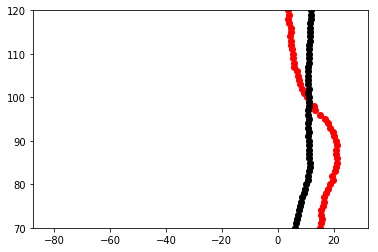

/home/silke/miniconda3/envs/wradlib_27/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-05-17 07:34:30.918938. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [25]:
timei=12
print(time[timei],topi[timei],bottomi[timei])
print(time[timei],bh[int(topi[timei])],bh[int(bottomi[timei])])
print(time[timei],bh[int(topi[timei])],bh[int(topi[timei]+10)])
ind=np.arange(0,550,1)
pl.plot(zh[:,timei]-20,ind, 'ro')
#pl.plot(rhohv[:,timei],ind, 'bo')
#pl.plot(zdr[:,timei],ind, 'ko')
pl.plot(phi[:,timei],ind, 'ko')
pl.ylim((70,120))
#ylim((0,3.7))
#pl.xlim((6,13))

Snowrate

In [30]:
# Multilinear fitting from Ryzhkov S=1.48*kdpdlg**0.61 * Zhdgl**0.33

Read temperature information

In [62]:
path="/home/silke/Python/projects/climatology/"
in_file_temp= open(path + "temp-" + date + ".dat","r")
ht8, ht10, ht15 =np.loadtxt(in_file_temp, skiprows=1, usecols = (1,2,3), dtype = 'f4')
print(ht8, ht10, ht15)

#90percentile of KDP, ZDR, Z between -10 and -15
#print(bh)

#ZDR in der DGL
zdrdgl=np.zeros(times)
#ZDR in der DGL
kdpdgl=np.zeros(times)

for i in range(len(bh)):
    if(bh[i]<ht10/1000.):
        ht10i=i
    if(bh[i]<ht15/1000.):
        ht15i=i
print(ht10i)
print(bh[ht10i], bh[ht15i])
# Determine 90percentile in the DGL
#Index des 90sten

for i in range(times):
    index=(int(len(zdr[ht10i:ht15i,i])*0.9))
    zdrs=sort(zdr[ht10i:ht15i,i]) 
    zdrdgl[i]=zdrs[index]
    print(zdrdgl[i])
    
for i in range(times):
    index=(int(len(kdp[ht10i:ht15i,i])*0.9))
    kdps=sort(kdp[ht10i:ht15i,i]) 
    kdpdgl[i]=kdps[index]
    print(kdpdgl[i])
    

(3750.0, 5100.0, 5800.0)
161
(5.0884678830672057, 5.7723312728367748)
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
-0.29953455925
-0.0778510570526
-0.103241682053
-0.0690619945526
0.061799287796
0.350865602493
0.404578447342
0.412390947342
0.371373414993
0.332310914993
0.395301103592
0.433875322342
0.495887041092
0.505164384842
0.503211259842
0.503699541092
0.485144853592
0.446082353592
0.422156572342
0.399207353592
0.448523759842
0.600381135941
0.455847978592
0.425574541092
0.373326539993
0.386511087418
0.402625322342
0.421180009842
0.479285478592
0.515420198441
0.534951448441
0.553506135941
0.551064729691
0.494910478592
0.490515947342
0.512977838516
0.479773759842
0.466101884842
0.460242509842
0.478797197342
0.177523851395
0.120393037796
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
-30.7999992371
nan
nan
na

In [15]:
fig, ax = pl.subplots(1, 4, figsize=(20,5))
vmin = -10
vmax = 65
clabel = 'Reflectivity [dBZ]'
ticks1 = np.arange(-10,65,5)
norm1 = get_norm(ticks1)
cmap = get_miub_cmap()
pm = ax[0].pcolormesh(lat1, hhl[0,0,:]/1000., slicedata, norm=norm1, cmap=cmap, vmin=ticks1[0],
              vmax=ticks1[-1])
pl.colorbar(pm, ax=ax[0])
ax[0].set_title(clabel, fontsize=13)
ax[0].set_xlabel("Longitude", fontsize=13)
ax[0].set_ylabel("Height", fontsize=13)
ax[0].tick_params(labelsize=13)

vmin = -0.25
vmax = 5.25
clabel = 'Differential Reflectivity [dB]'
ticks1 = np.arange(vmin,vmax,0.25)
norm1 = get_norm(ticks1)
cmap = get_miub_cmap()
slicedatazdr[slicedata < -5] = np.nan
#wenn ich mal gegen lon1 und mal lat1 ists vertauscht, eher oben und unten
pm = ax[1].pcolormesh(lat1, hhl[0,0,:]/1000., slicedatazdr, norm=norm1, cmap=cmap, vmin=ticks1[0],
              vmax=ticks1[-1])
pl.colorbar(pm, ax=ax[1])
ax[1].set_title(clabel, fontsize=13)
ax[1].set_xlabel("Longitude", fontsize=13)
ax[1].set_ylabel("Height", fontsize=13)
ax[1].tick_params(labelsize=13)


vmin = -1
vmax = 3
clabel = 'Specific Differential Phase [deg/km]'
ticks1 = np.arange(vmin, vmax, 0.1)
norm1 = get_norm(ticks1)
cmap = get_miub_cmap()
slicedatakdp[slicedata < -5] = np.nan
pm = ax[2].pcolormesh(lat1, hhl[0,0,:]/1000., slicedatakdp, norm=norm1, cmap=cmap, vmin=ticks1[0],
              vmax=ticks1[-1])
pl.colorbar(pm, ax=ax[2])
ax[2].set_title(clabel, fontsize=13)
ax[2].set_xlabel("Latitude", fontsize=13)
ax[2].set_ylabel("Height", fontsize=13)
ax[2].tick_params(labelsize=13)

vmin = 0.7
vmax = 1.0
clabel = 'Correlation Coefficient []'
ticks1 = [0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.985, 0.99, 0.995, 1.0]
norm1 = get_norm(ticks1)
slicedatarhv[slicedata < -5] = np.nan
pm = ax[3].pcolormesh(lat1, hhl[0,0,:]/1000., slicedatarhv, norm=norm1, cmap=cmap, vmin=ticks1[0],
              vmax=ticks1[-1])
pl.colorbar(pm, ax=ax[3])
ax[3].set_title(clabel, fontsize=13)
ax[3].set_xlabel("Latitude", fontsize=13)
ax[3].set_ylabel("Height", fontsize=13)
ax[3].tick_params(labelsize=13)

ax[0].set_ylim((0,15))
ax[1].set_ylim((0,15))
ax[2].set_ylim((0,15))
ax[3].set_ylim((0,15))
pl.tight_layout()
pl.savefig('/home/silke/ACPC/Figures/' + filein[0:12] + 'RHI' + '.png')
#ax[0,0].set_xlim((5.5,8.5))
#ax[0,1].set_xlim((49.7,52))

In [17]:
#pl.pcolormesh(lon.reshape((461, 421)), lat.reshape((461, 421)), zh[:,:,49].T)
#pl.pcolormesh(lon[30,:], h, zh[30,:,:].T)
#print(lat[0,:])
#fig = pl.figure(figsize=(10,6))
fig, ax = pl.subplots(1, 4, figsize=(20,3.5))
#pl.show()
print(ax)
site=(7.071663, 50.73052)
proj_wgs84 = wrl.georef.get_default_projection()

vmin = -10
vmax = 65
clabel = 'Reflectivity [dBZ]'
ticks1 = np.arange(-10,65,5)
norm1 = get_norm(ticks1)
cmap = get_miub_cmap()
ax1 = ax[0]
print(proj_wgs84)

pm = ax1.pcolormesh(lon, lat, zh[:,:,38].T, norm=norm1, cmap=cmap, vmin=ticks1[0],
                         vmax=ticks1[-1], zorder=0)
wrl.vis.plot_ppi_crosshair(site=site, ranges=[25000, 50000,100000], 
                               line=dict(color='black'),
                               circle={'edgecolor': 'black'},
                               proj=proj_wgs84, ax=ax1, zorder=2)
p1 = [7.071663, 6.44]
p2 = [50.73052, 50.94]
ax1.plot(p1,p2,'g--')
#pm = ax1.pcolormesh(zh[:,:,43].T, norm=norm1, cmap=cmap, vmin=ticks1[0],
#              vmax=ticks1[-1], zorder=0)
pl.colorbar(pm, ax=ax1)
ax1.set_title(clabel)
#ax1.set_xlim((6.0,6.5))
#ax1.set_ylim((49.5,50.5))
ax1.set_xlim((5.5,8.5))
ax1.set_ylim((49.5,52.0))


ax2 = ax[1]#pl.subplot(2, 1, 2)
vmin = -0.25
vmax = 5.25
clabel = 'Differential Reflectivity [dB]'
ticks1 = np.arange(vmin,vmax,0.25)
norm1 = get_norm(ticks1)
cmap = get_miub_cmap()
zdr[zh < -5.0] = np.nan
#zdr = np.masked_where(zh < -5.0, zdr, copy=True)
wrl.vis.plot_ppi_crosshair(site=site, ranges=[25000, 50000,100000], 
                               line=dict(color='black'),
                               circle={'edgecolor': 'black'},
                               proj=proj_wgs84, ax=ax2, zorder=2)
pm= ax2.pcolormesh(lon, lat, zdr[:,:,38].T, norm=norm1, cmap=cmap, vmin=ticks1[0],
              vmax=ticks1[-1])
ax2.plot(p1,p2,'g--')
pl.colorbar(pm, ax=ax2)
ax2.set_title(clabel)
ax2.set_xlim((5.5,8.5))
ax2.set_ylim((49.5,52.0))

ax3 = ax[2]
vmin = -1
vmax = 3
clabel = 'Specific Differential Phase [deg/km]'
ticks1 = np.arange(vmin, vmax, 0.1)
norm1 = get_norm(ticks1)
kdp[zh < -5.0] = np.nan
pm = ax3.pcolormesh(lon, lat, kdp[:,:,38].T, norm=norm1, cmap=cmap, vmin=ticks1[0],
              vmax=ticks1[-1], zorder=0)
ax3.plot(p1,p2,'g--')
ax3.set_xlim((5.5,8.5))
ax3.set_ylim((49.5,52.0))
pl.colorbar(pm, ax=ax3)
ax3.set_title(clabel)

wrl.vis.plot_ppi_crosshair(site=site, ranges=[25000, 50000,100000], 
                               line=dict(color='black'),
                               circle={'edgecolor': 'black'},
                               proj=proj_wgs84, ax=ax3, zorder=2)
##pl.subplots_adjust(wspace=0.5, hspace=0.5)
#pl.show()


ax4 = ax[3]
vmin = 0.7
vmax = 1.0
clabel = 'Correlation Coefficient []'
ticks1 = [0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.985, 0.99, 0.995, 1.0]
norm1 = get_norm(ticks1)
norm1 = get_norm(ticks1)
pm = ax4.pcolormesh(lon, lat, rhv[:,:,38].T, norm=norm1, cmap=cmap, vmin=ticks1[0],
              vmax=ticks1[-1], zorder=0)
ax4.plot(p1,p2,'g--')
ax4.set_xlim((5.5,8.5))
ax4.set_ylim((49.5,52.0))
pl.colorbar(pm, ax=ax4)
ax4.set_title(clabel)
wrl.vis.plot_ppi_crosshair(site=site, ranges=[25000, 50000,100000], 
                               line=dict(color='black'),
                               circle={'edgecolor': 'black'},
                               proj=proj_wgs84, ax=ax4, zorder=2)
#fig = plt.gcf()
pl.tight_layout()
pl.savefig('/home/silke/ACPC/Figures/' + filein[0:12] +'PPI' + '.png')

GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
